# IA pour environnement - TP2

Gaspard Berthelier

## 1. Introduction

L'objectif de ce TP est de se familiariser avec l'analyse de séries temporelles liées à l'environnement et le climat. Il est constitué d'une première étape d'analyse de données puis d'une seconde d'évaluation de modèles d'apprentissage.

Le contexte du TP est le suivant : le Groenland possède la deuxième plus grande calotte polaire du monde. Sa fonte contribue à l'élévation du niveau de la mer, ce qui affecte non seulement les populations côtières mais également le climat global. Il est donc crucial de monitorer les événements climatiques qui s'y déroulent.

Par ailleurs, dans le cadre du Traité d'Interdiction Complète des Essais Nucléaires (TICE) et plus particulièrement du Système de Surveillance International (SSI) qui en découle, la station infrasonore IS18 à Qaanaaq enregistre des signaux infrasons afin de détecter divers événements "anormaux".

L'utilisation de méthodes d'apprentissage machine sur ces signaux permettrait entre autres de détecter des événements liés à la fonte des glaces.

## 2. Données

Nous avons accès à plusieurs sources de données :

- des **données infrasons** (différentiels de pression) séparées en 5 séries temporelles selon l'origine géographique du phénomène et sa saisonnalité. Cette distinction a été calculée grâce à la méthode Progressive MultiChannel Correlation (PMCC) qui analyse les corrélations des mesures provenant des huits capteurs de la station. Ces séries temporelles ont par la suite été binarisées, avec 1 quand il y a détection d'un événement et 0 sinon. Elles ont ensuite été moyénnées sur des périodes de 1 jour.

- des **réanalyse climatiques** (données européennes) de températures atmosphérique et à la surface de la mer ainsi que de vitesse de vent selon deux directions.

- des **données satellitaires** de concentration en glace de la mer.

- des **simulations de décharge** d'eau (modèle MAR) sur 5 régions autour de Qaanaq.

## 3. Analyse des données

Dans cette section, je réponds aux questions 1 à 7 (pas forcément dans l'ordre selon la pertinenceà, pour chaque ensemble de variables séparement, puis aux question 8 et 9 à la fin.

### Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd '/content/drive/MyDrive/IA/'

Mounted at /content/drive
/content/drive/MyDrive/IA


In [ ]:
import ia_env_tp2 as fct #fichier py que j'ai écrit pour diverses fonctions

import importlib
importlib.reload(fct)

<module 'ia_env_tp2' from '/content/drive/MyDrive/IA/ia_env_tp2.py'>

In [ ]:
df_targets = pd.read_csv("Daily_Targets.csv")
df_features = pd.read_csv("Daily_Features.csv")

### Infrasons

In [ ]:
df_infrason = df_targets.rename(columns={"Unnamed: 0":"date"})
df_infrason.drop(columns=["Y3","Y4","Y5"],inplace=True)

In [ ]:
print("Features : ",list(df_features.columns))
print("Targets : ",list(df_infrason.columns))

Features :  ['time', 't2m', 'u10', 'v10', 'SST', 'SIC', 'r1_MAR', 'r2_MAR', 'r3_MAR', 'r4_MAR', 'r5_MAR']
Targets :  ['date', 'Y1']


In [ ]:
print("Feature NaNs : ",np.where(df_features.isna())[0])
print("Target NaNs : ",np.where(df_targets.isna())[0])

Feature NaNs :  []
Target NaNs :  []


In [ ]:
N = df_infrason.shape[0]
print("Days : ",N)
print("Start : ",df_infrason.date[0])
print("End : ",df_infrason.date[df_infrason.shape[0]-1])
N_years = 7

Days :  2556
Start :  2013-01-01
End :  2019-12-31


Il y a des données pour 7 années. Je vais ajouter des barres verticales pour demarquer la séparation annuelle dans les plots qui suivent.



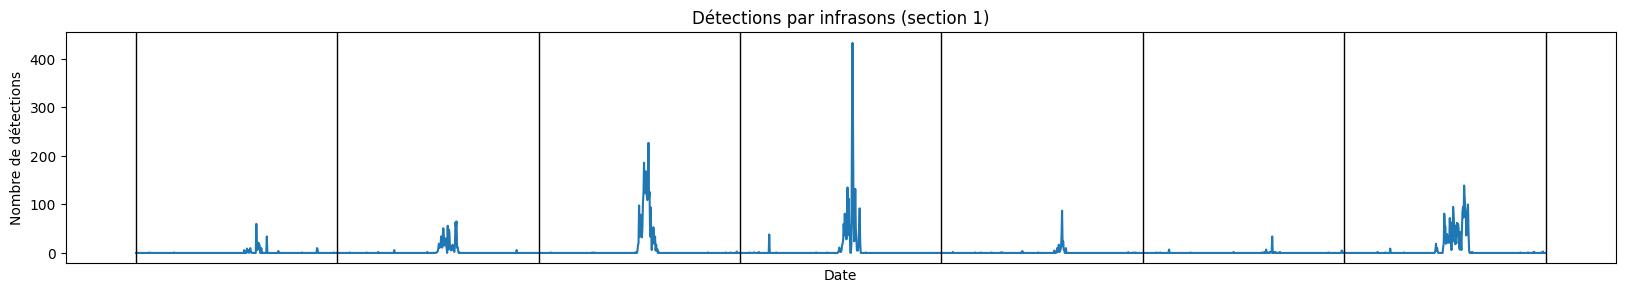

In [ ]:
plt.figure(figsize=(20,3))
plt.plot(range(df_infrason.shape[0]),df_infrason.Y1.values)
plt.title("Détections par infrasons (section 1)")
plt.xticks([])
plt.ylabel("Nombre de détections")
plt.xlabel("Date")
for k in range(N_years+1):
  plt.axvline(x=k*N//N_years, color='black', linewidth=1)
plt.show();

Il semble y avoir une période (autour du milieu de l'année) où un grand nombre d'événements sont détectés. Mais ce n'est pas le même nombre chaque année. On va considérer la présence d'un évenement rare si le nombre de détections est supérieur à un certain seuil.

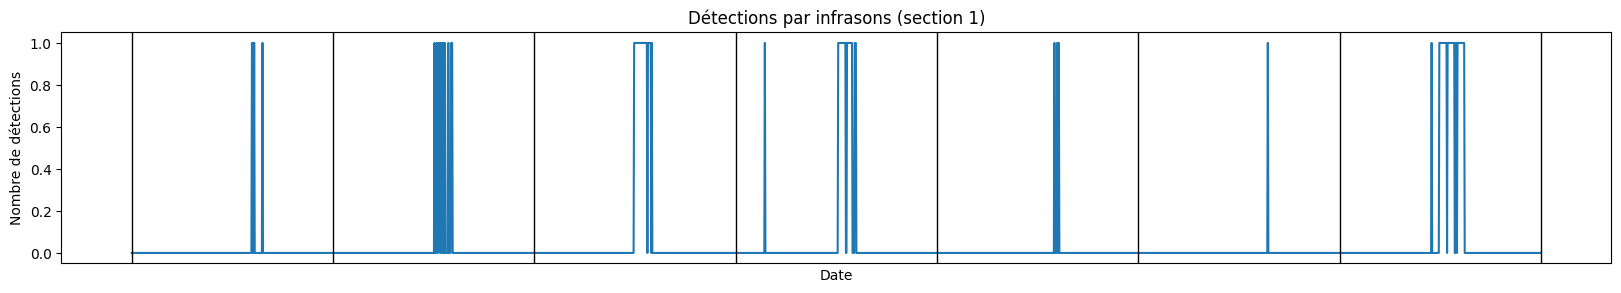

In [ ]:
thresh = df_infrason.Y1.quantile(.95) # > 95% des cas
var_bin = 1 * (df_infrason.Y1 > thresh)

plt.figure(figsize=(20,3))
plt.plot(range(df_infrason.shape[0]),var_bin)
plt.title("Détections par infrasons (section 1)")
plt.xticks([])
plt.ylabel("Nombre de détections")
plt.xlabel("Date")
for k in range(N_years+1):
  plt.axvline(x=k*N//N_years, color='black', linewidth=1)
plt.show();

### Réanalyses climatiques

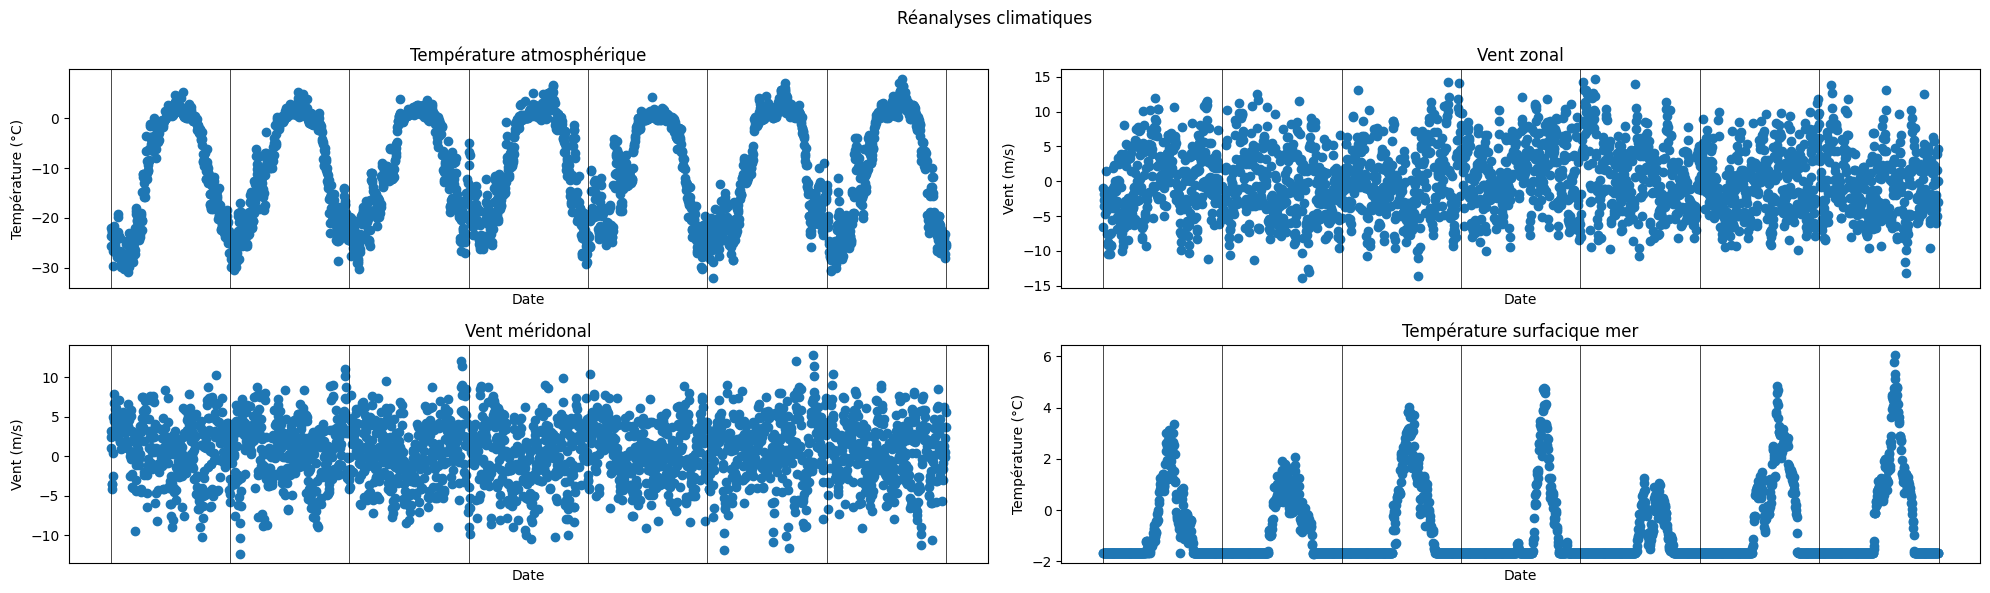

In [ ]:
#Visualisations

df_climat = df_features[["t2m","u10","v10","SST"]]
df_climat = df_climat.rename(columns={"t2m":"temp_atmos","u10":"vent_u","v10":"vent_v","SST":"temp_mer"})

fig, axs = plt.subplots(2, 2, figsize=(20, 6))

axs[0, 0].scatter(range(df_climat.shape[0]),df_climat['temp_atmos'])
axs[0, 0].set_title('Température atmosphérique')
axs[0, 0].set_ylabel('Température (°C)')

axs[0, 1].scatter(range(df_climat.shape[0]),df_climat['vent_u'])
axs[0, 1].set_title('Vent zonal')
axs[0, 1].set_ylabel('Vent (m/s)')

axs[1, 0].scatter(range(df_climat.shape[0]),df_climat['vent_v'])
axs[1, 0].set_title('Vent méridonal')
axs[1, 0].set_ylabel('Vent (m/s)')

axs[1, 1].scatter(range(df_climat.shape[0]),df_climat['temp_mer'])
axs[1, 1].set_title('Température surfacique mer')
axs[1, 1].set_ylabel('Température (°C)')

fct.add_temporality(axs,N,N_years)

fig.suptitle("Réanalyses climatiques")
plt.tight_layout()
plt.show();

On voit qu'il y a une cyclicité à l'année sur les températures. C'est cohérent, celles-ci augmentent en été. Pour la vitesse des vents, celle-ci est moins visible mais il semblerait y avoir une oscillation avec une baisse de vitesse au milieu de l'année.

Enfin, il semblerait qu'il y ait des valeurs manquantes pour la température surfacique de la mer, dés que la tempratures s'approchent de -2°C. Je fais l'hypothèse qu'il s'agit du moment où l'eau gèle. Si ce n'est pas le cas, il est possible de remplacer les valeurs manquantes par une courbe sinusoïdale similaire à celle des temperatures atmosphériques. J'ai décidé d'opter pour la première hypothèse.

In [ ]:
#Statistiques
df_climat.describe()

,temp_atmos,vent_u,vent_v,temp_mer
count,2556.000000,2556.000000,2556.000000,2556.000000
mean,-10.190040,0.139648,0.626351,-0.858922
std,10.340583,5.013640,3.955417,1.446165
min,-32.019122,-13.846656,-12.316128,-1.692462
25%,-19.877500,-3.610168,-2.079422,-1.689860
50%,-9.596479,-0.187084,0.912780,-1.689860
75%,0.167824,3.807440,3.483397,-0.297573
max,7.840619,14.640913,12.811255,6.054536


Les valeurs de températures sont cohérentes (il fait froid au Groenland!). On voit que la température surface de la mer varie beaucoup moins que celle atmosphérique. Même si cela peut être en partie causé par les valeurs manquantes fixées à ~-2°C, c'est surtout car l'inertie de l'océan est bien plus grande que celle de l'atmosphère.

Les valeurs négatives de la vitesse du vent indiquent la direction de celui-ci.

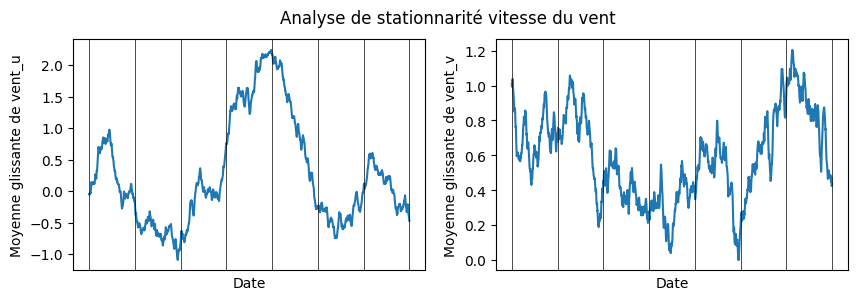

In [ ]:
#Stationarité
fig, axs = fct.check_stationarity(df_climat,["vent_u","vent_v"],window=365)
fig.suptitle("Analyse de stationnarité vitesse du vent")
fct.add_temporality(axs,N-365,N_years)

On constate effectivement que la vitesse du vent n'est pas stationnaire. Vu les variations rapides de la vitesse du vent, il sera peut-être intéressant d'ajouter cette variable moyennée pour avoir une idée de la tendance du vent.

Les séries cycliques quant-à-elles ne sont évidemment pas stationnaires.

<Figure size 640x480 with 0 Axes>

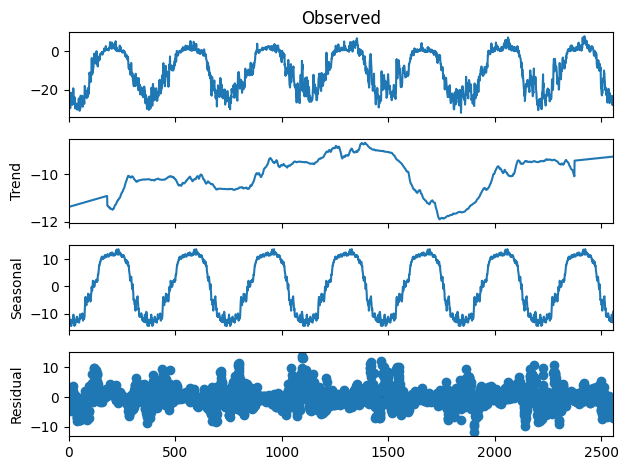

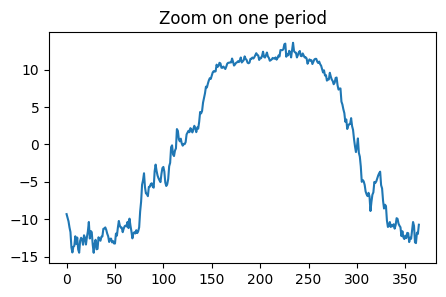

In [ ]:
#Cyclicity
fct.plot_seasonality(df_climat,'temp_atmos',period=365)

On peut voir qu'il y a effectivement une cyclicité annuelle, avec un pic cohérent en été. Il pourra être intéressant d'isoler la tendance décorrélée de ce cycle (on constate une chute à la fin de sixième année).


 Nous allons maintenant regarder s'il en existe d'autres (mensuelle, saisonale, ...) sur les 4 séries temporelles.

In [ ]:
#FFT pour trouver les meillueres périodes
fct.get_best_period(df_climat["temp_atmos"])
fct.get_best_period(df_climat["temp_mer"])
fct.get_best_period(df_climat["vent_u"])
fct.get_best_period(df_climat["vent_v"])

Period :  365.143
Period :  365.143
Period :  53.25
Period :  365.143


interactive(children=(Dropdown(description='col', options=('temp_atmos', 'temp_mer', 'vent_u', 'vent_v'), valu…

<function ia_env_tp2.plot_seasonality(df, col=None, period=None)>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

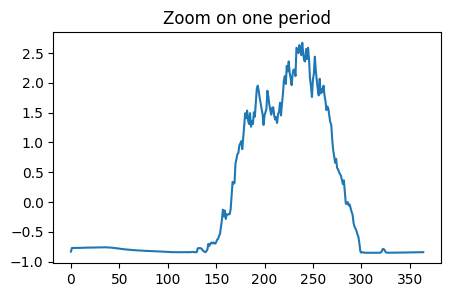

In [77]:
#j'utilise ipywidgets pour selectionner la série et la période à tester. Sinon on se retrouve avec beaucoup trop de plots
import ipywidgets

series_to_test = ['temp_atmos','temp_mer','vent_u','vent_v']
periods_to_test = [7,30,53,365//4,365]
ipywidgets.interact(fct.plot_seasonality,df=ipywidgets.fixed(df_climat),col=series_to_test,period=periods_to_test)

Il semblerait que la seule tendance pertinente est celle qui réalise une oscillation par an pour les températures. Il semblerait donc judicieux d'utiliser une variable calendaire pour le jour de l'année, en force de sinusoïde (dont les extremums se situe sur été/hiver). De plus, on isolera les tendances.

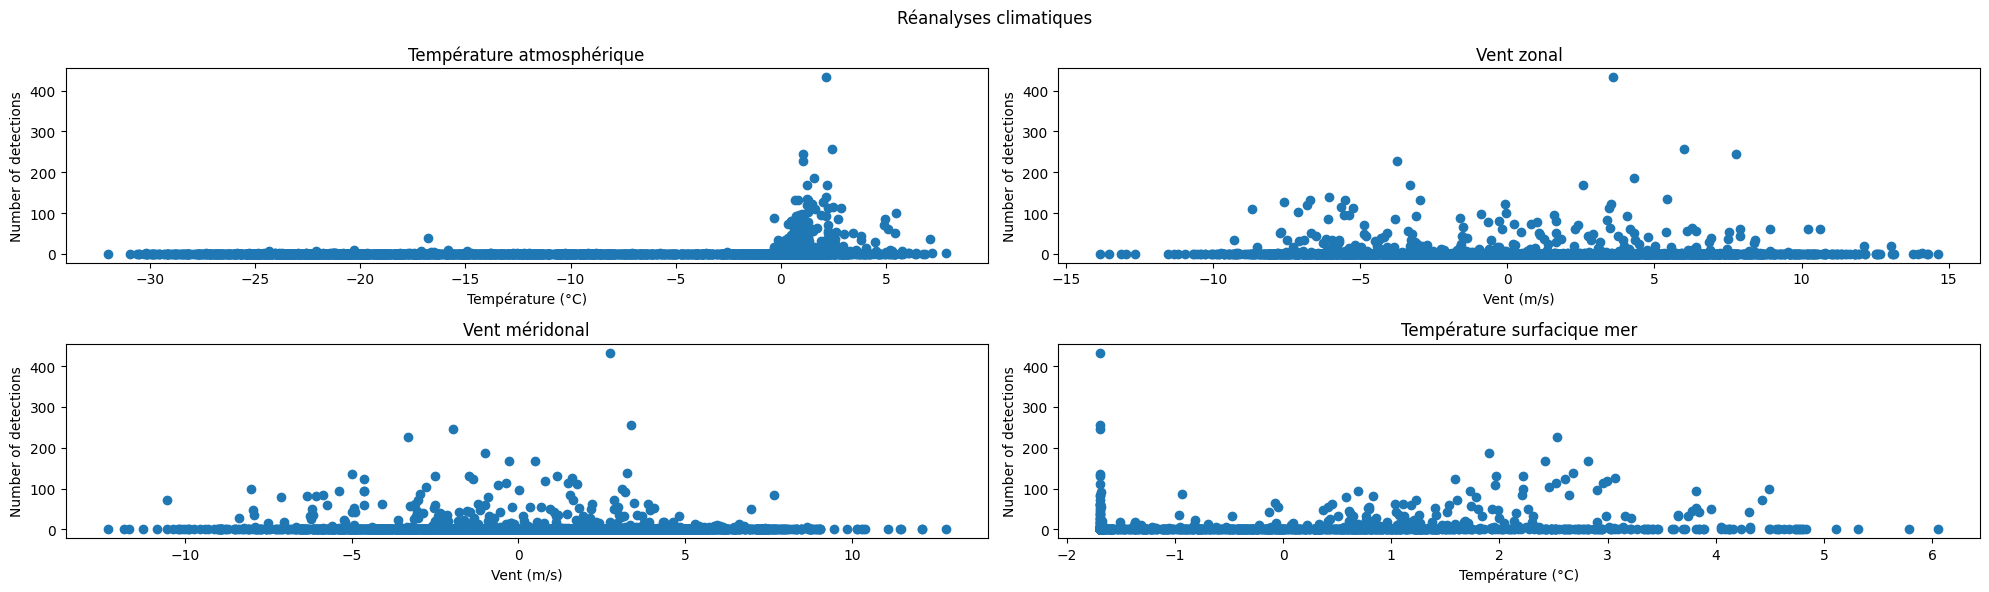

In [ ]:
#Visualisation en fonction des événements
fig, axs = plt.subplots(2, 2, figsize=(20, 6))

axs[0, 0].scatter(df_climat['temp_atmos'], df_infrason['Y1'])
axs[0, 0].set_title('Température atmosphérique')
axs[0, 0].set_xlabel('Température (°C)')
axs[0, 0].set_ylabel('Number of detections')

axs[0, 1].scatter(df_climat['vent_u'], df_infrason['Y1'])
axs[0, 1].set_title('Vent zonal')
axs[0, 1].set_xlabel('Vent (m/s)')
axs[0, 1].set_ylabel('Number of detections')

axs[1, 0].scatter(df_climat['vent_v'], df_infrason['Y1'])
axs[1, 0].set_title('Vent méridonal')
axs[1, 0].set_xlabel('Vent (m/s)')
axs[1, 0].set_ylabel('Number of detections')

axs[1, 1].scatter(df_climat['temp_mer'], df_infrason['Y1'])
axs[1, 1].set_title('Température surfacique mer')
axs[1, 1].set_xlabel('Température (°C)')
axs[1, 1].set_ylabel('Number of detections')

fig.suptitle("Réanalyses climatiques")
plt.tight_layout()
plt.show()

Il semblerait que les événements aient lieux souvent lors de grandes températures atmosphériques. Mais il faut faire attention à ce que cela ne soit pas du simplement au fait qu'il y a souvent des température entre 0 et 5.

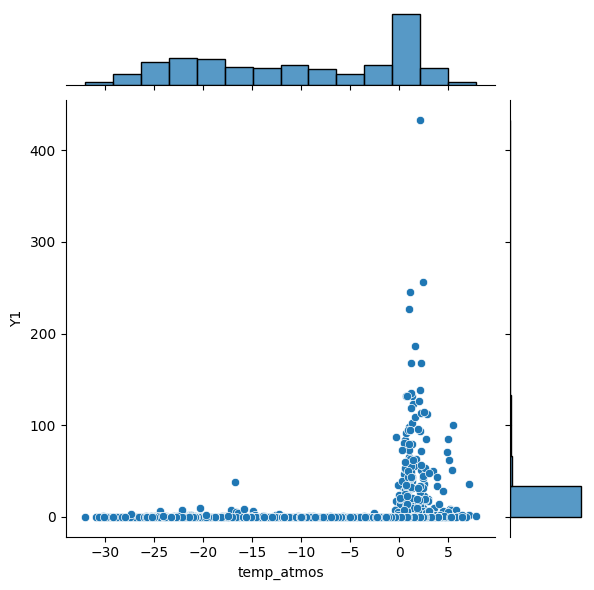

In [ ]:
sns.jointplot(x=df_climat['temp_atmos'], y=df_infrason['Y1'])

En effet ceci explique cela.

### Données satellitaires

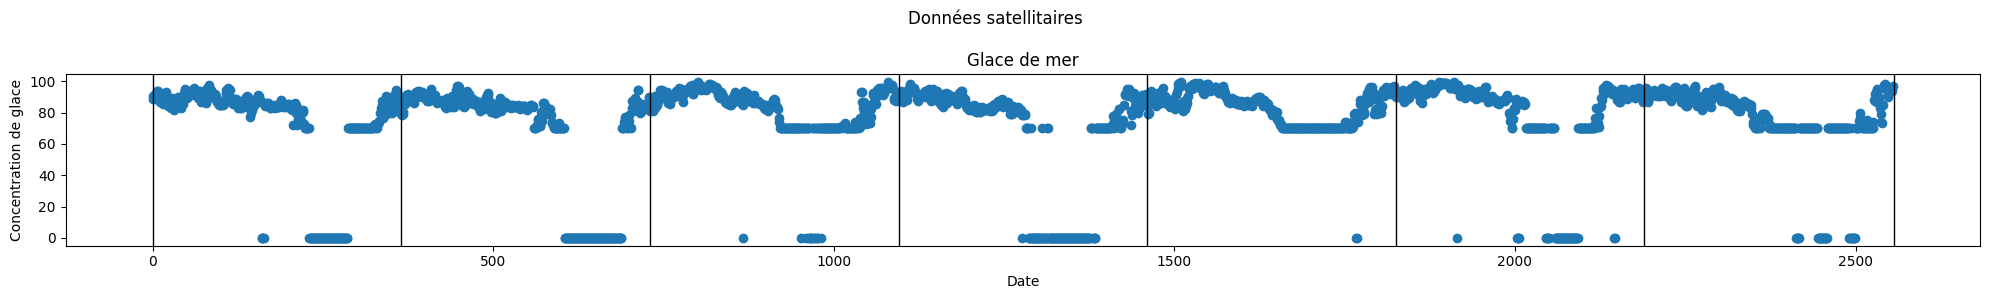

In [ ]:
#Visualisation

df_sat = df_features[["SIC"]]
df_sat = df_sat.rename(columns={"SIC":"ice"})

fig = plt.figure(figsize=(20, 3))

plt.scatter(range(df_sat.shape[0]),df_sat['ice'])
plt.title('Glace de mer')
plt.ylabel('Concentration de glace')
plt.xlabel('Date')

for k in range(N_years+1):
  plt.axvline(x=k*N//N_years, color='black', linewidth=1)

fig.suptitle("Données satellitaires")
plt.tight_layout()
plt.show();

A nouveau, il apparaît un cycle annuel. Cependant, ici il y a clairement des valeurs manquantes. On peut au moins les remplacer par une valeur plus proche.

Nombre de valeurs manquantes :  325


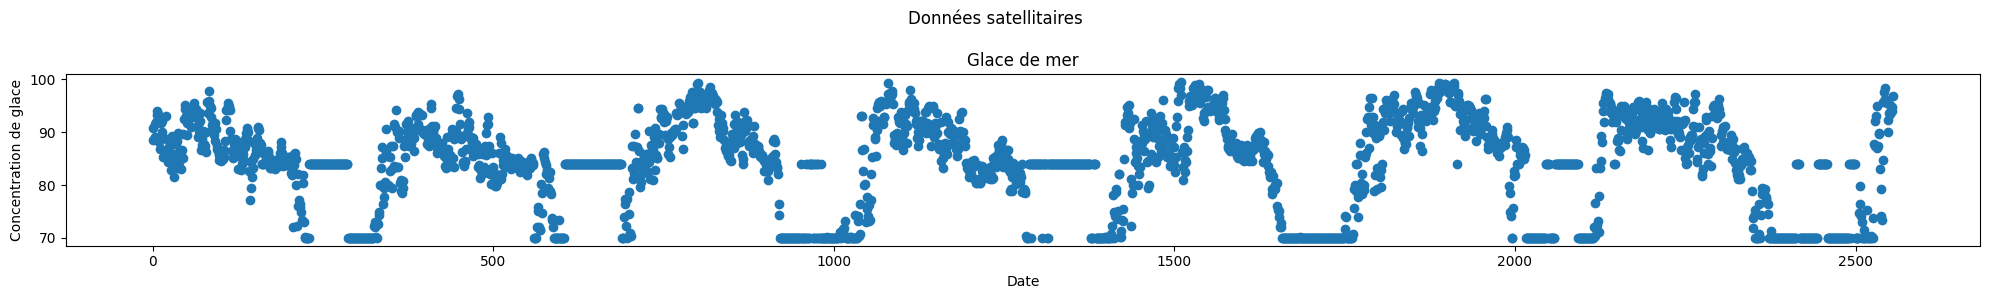

In [ ]:
#par la moyenne
imputed_ice = fct.impute_missing(df_sat.ice.values,missing_value=0)

fig = plt.figure(figsize=(20, 3))
plt.scatter(range(df_sat.shape[0]),imputed_ice)
plt.title('Glace de mer')
plt.ylabel('Concentration de glace')
plt.xlabel('Date')
fig.suptitle("Données satellitaires")
plt.tight_layout()
plt.show();

Nombre de valeurs manquantes :  325


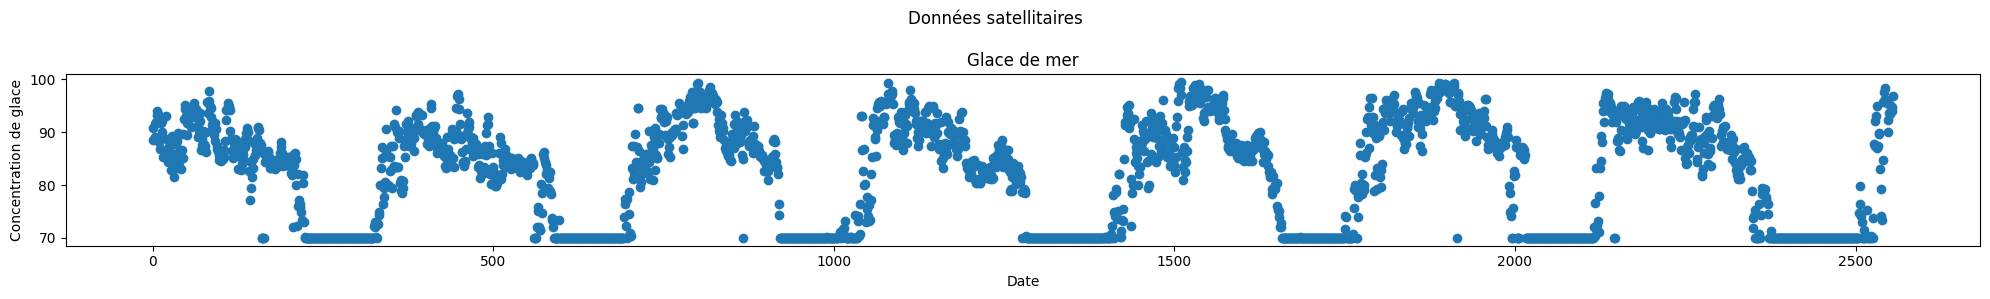

In [ ]:
#par le minimum
imputed_ice = fct.impute_missing(df_sat.ice.values,missing_value=0,strategy="constant",fill_value=70)

fig = plt.figure(figsize=(20, 3))
plt.scatter(range(df_sat.shape[0]),imputed_ice)
plt.title('Glace de mer')
plt.ylabel('Concentration de glace')
plt.xlabel('Date')
fig.suptitle("Données satellitaires")
plt.tight_layout()
plt.show();

Il semble plus pertinent de remplacer les valeurs manquantes par 70 plutôt que par la moyenne . Cela créé quelques points abérrants (ceux à 70 au niveau des bosses) mais en minorité comparé aux autres.

In [ ]:
#Statistiques
df_sat["ice"] = imputed_ice
df_sat.describe()

,ice
count,2556.000000
mean,82.168434
std,9.740184
min,70.000000
25%,70.000000
50%,84.601769
75%,90.362319
max,99.500682


Period :  365.143


interactive(children=(Text(value='ice', description='col'), Dropdown(description='period', options=(7, 30, 53,…

<function ia_env_tp2.plot_seasonality(df, col=None, period=None)>

<Figure size 640x480 with 0 Axes>

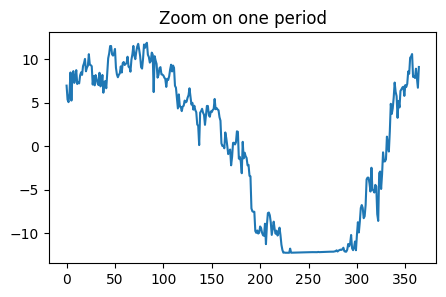

In [78]:
fct.get_best_period(df_sat["ice"])
periods_to_test = [7,30,53,365//4,365]
ipywidgets.interact(fct.plot_seasonality,df=ipywidgets.fixed(df_sat),col="ice",period=periods_to_test)

La concentration en glace est plus grande en hiver (fin et début d'année) ce qui est cohérent. On constate une tendance de hausse de concentration, notamment vers la sixième année. C'était justement cette année où l'on avait observé une baisse tendancielle de la témpérature.

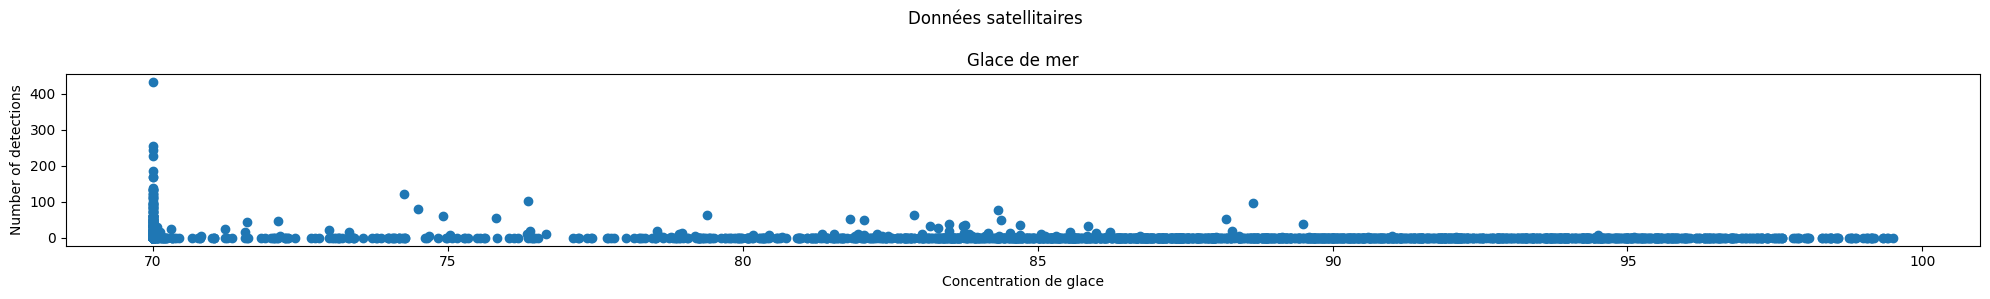

In [ ]:
#Visualisation des détections
fig = plt.figure(figsize=(20, 3))

plt.scatter(df_sat["ice"], df_targets['Y1'])
plt.title('Glace de mer')
plt.xlabel('Concentration de glace')
plt.ylabel('Number of detections')

fig.suptitle("Données satellitaires")
plt.tight_layout()
plt.show();

Le pic en 70 est dû au fait qu'un grand nombre de concentrations sont à 70 (du fait du remplissage des valeurs manquantes)

### Simulations décharge

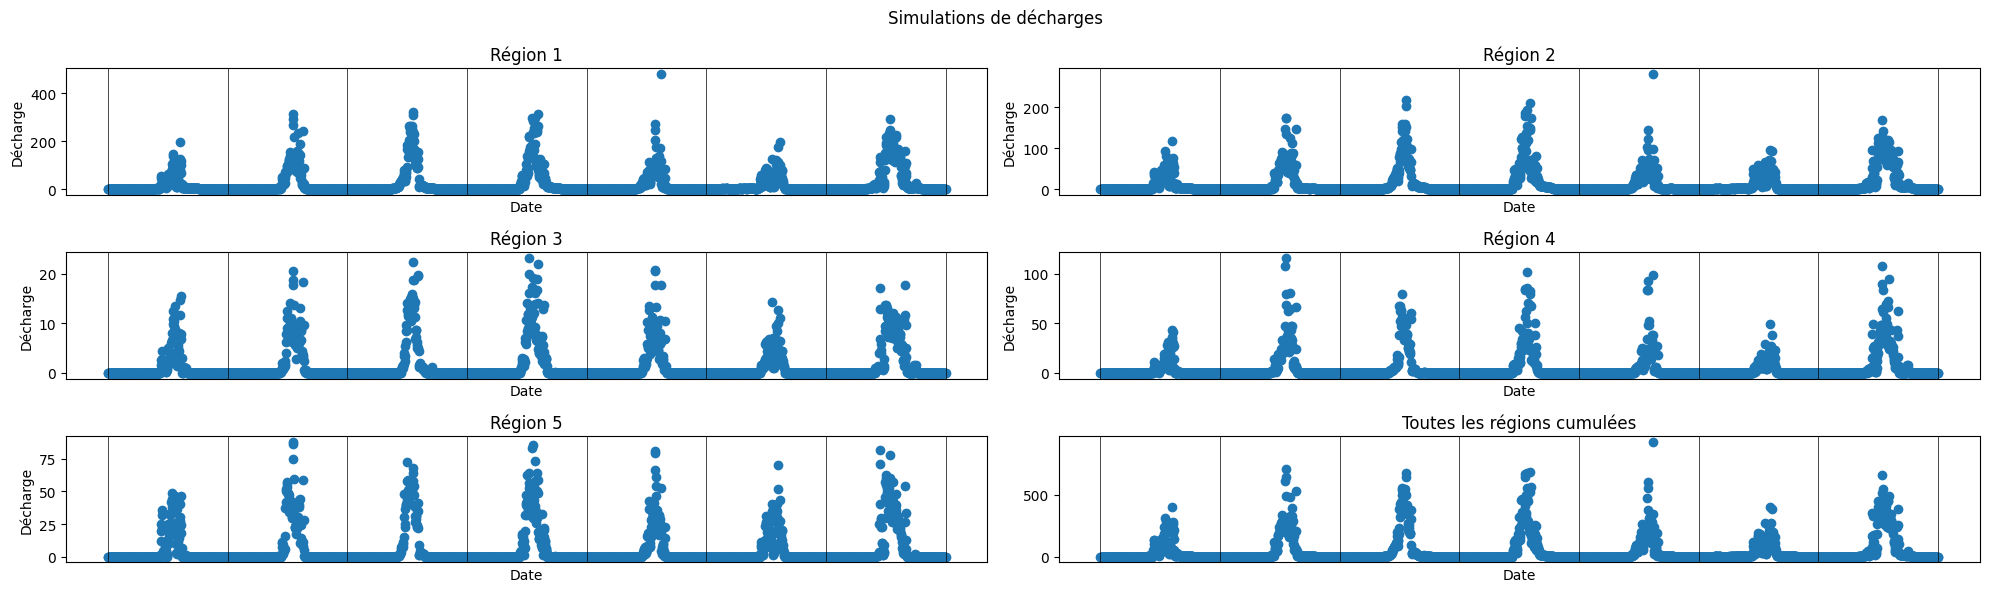

In [ ]:
#Visualisation

df_simu = df_features[['r1_MAR', 'r2_MAR', 'r3_MAR','r4_MAR', 'r5_MAR']]
df_simu = df_simu.rename(columns={"r1_MAR":"r1","r2_MAR":"r2","r3_MAR":"r3","r4_MAR":"r4","r5_MAR":"r5"})

fig, axs = plt.subplots(3, 2, figsize=(20, 6))

axs[0, 0].scatter(range(df_simu.shape[0]),df_simu['r1'])
axs[0, 0].set_title('Région 1')
axs[0, 0].set_ylabel('Décharge')
axs[0, 0].set_xlabel('Date')

axs[0, 1].scatter(range(df_simu.shape[0]),df_simu['r2'])
axs[0, 1].set_title('Région 2')
axs[0, 1].set_ylabel('Décharge')
axs[0, 0].set_xlabel('Date')

axs[1, 0].scatter(range(df_simu.shape[0]),df_simu['r3'])
axs[1, 0].set_title('Région 3')
axs[1, 0].set_ylabel('Décharge')
axs[0, 0].set_xlabel('Date')

axs[1, 1].scatter(range(df_simu.shape[0]),df_simu['r4'])
axs[1, 1].set_title('Région 4')
axs[1, 1].set_ylabel('Décharge')
axs[0, 0].set_xlabel('Date')

axs[2, 0].scatter(range(df_simu.shape[0]),df_simu['r5'])
axs[2, 0].set_title('Région 5')
axs[2, 0].set_ylabel('Décharge')
axs[0, 0].set_xlabel('Date')

df_simu["r_total"] = df_simu['r1']+df_simu['r2']+df_simu['r3']+df_simu['r4']+df_simu['r5']
axs[2, 1].scatter(range(df_simu.shape[0]),df_simu['r_total'])
axs[2, 1].set_title('Toutes les régions cumulées')
axs[2, 1].set_xlabel('Décharge')
axs[0, 0].set_xlabel('Date')

fct.add_temporality(axs,N,N_years)

fig.suptitle("Simulations de décharges")
plt.tight_layout()
plt.show()

A nouveau, une cyclicté annuelle avec des pics en été.

In [ ]:
#Statistiques
df_simu.describe()

,r1,r2,r3,r4,r5,r_total
count,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000
mean,18.789275,11.522362,1.328740,4.382248,5.191286,41.213910
std,47.703600,27.942124,3.393452,12.971518,13.406972,103.707157
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.123798,0.121437,0.000000,0.000000,0.000000,0.247524
50%,0.481870,0.481870,0.000000,0.000000,0.000000,0.963739
75%,4.080174,3.961181,0.004413,0.010148,0.000150,8.399302
max,479.722174,281.673389,23.241791,115.876574,88.054318,930.939288


On constate que les amplitudes ne sont pas du tout les mêmes entre les régions. On peut cependant reconnaître la proximité géométrique de certaines régions, en particulier 4 et 5.

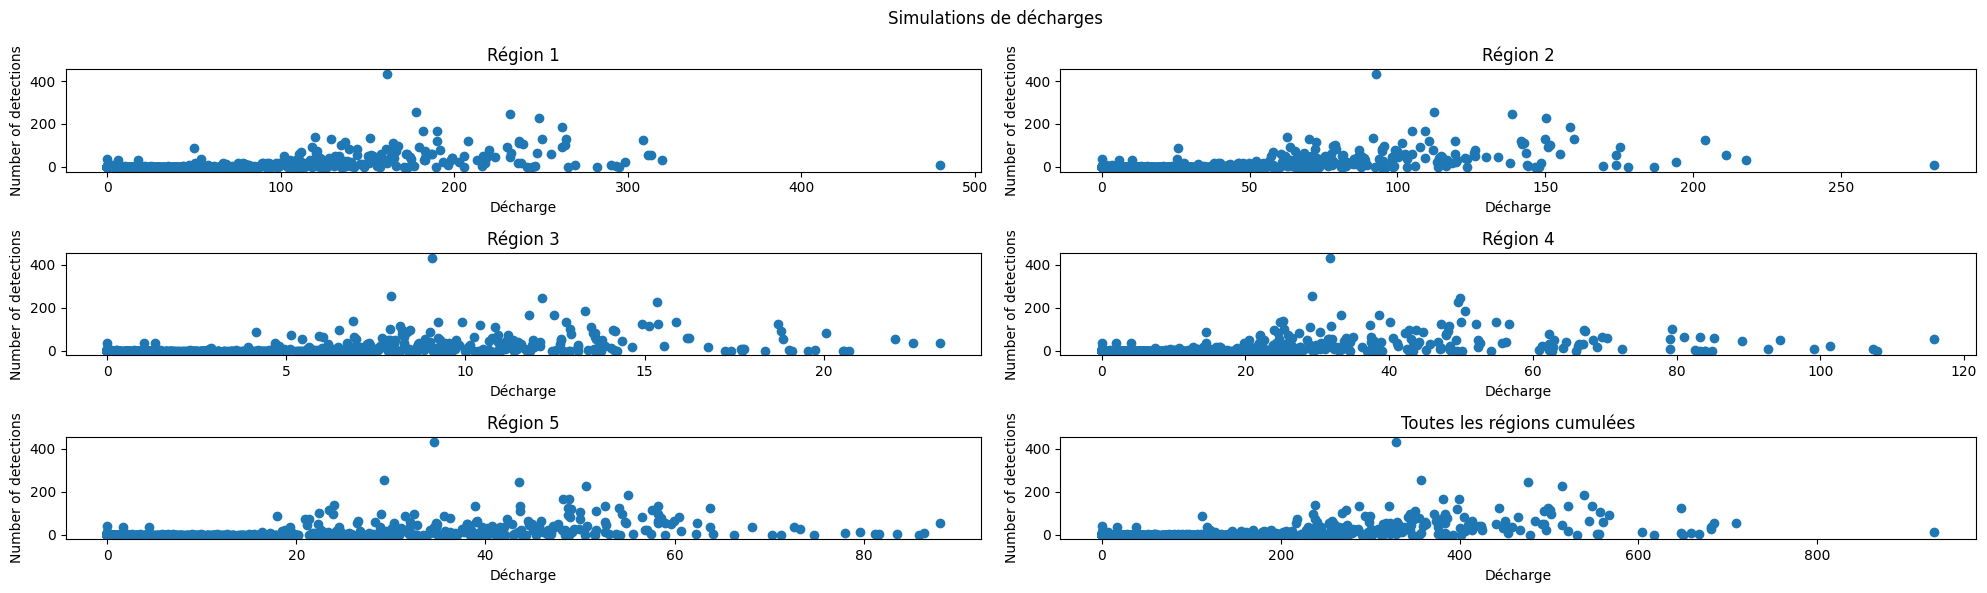

In [ ]:
#données simulées

fig, axs = plt.subplots(3, 2, figsize=(20, 6))

axs[0, 0].scatter(df_simu['r1'], df_infrason['Y1'])
axs[0, 0].set_title('Région 1')
axs[0, 0].set_xlabel('Décharge')
axs[0, 0].set_ylabel('Number of detections')

axs[0, 1].scatter(df_simu['r2'], df_infrason['Y1'])
axs[0, 1].set_title('Région 2')
axs[0, 1].set_xlabel('Décharge')
axs[0, 1].set_ylabel('Number of detections')

axs[1, 0].scatter(df_simu['r3'], df_infrason['Y1'])
axs[1, 0].set_title('Région 3')
axs[1, 0].set_xlabel('Décharge')
axs[1, 0].set_ylabel('Number of detections')

axs[1, 1].scatter(df_simu['r4'], df_infrason['Y1'])
axs[1, 1].set_title('Région 4')
axs[1, 1].set_xlabel('Décharge')
axs[1, 1].set_ylabel('Number of detections')

axs[2, 0].scatter(df_simu['r5'], df_infrason['Y1'])
axs[2, 0].set_title('Région 5')
axs[2, 0].set_xlabel('Décharge')
axs[2, 0].set_ylabel('Number of detections')

axs[2, 1].scatter(df_simu['r_total'], df_infrason['Y1'])
axs[2, 1].set_title('Toutes les régions cumulées')
axs[2, 1].set_xlabel('Décharge')
axs[2, 1].set_ylabel('Number of detections')

fig.suptitle("Simulations de décharges")
plt.tight_layout()
plt.show()

### Correlations

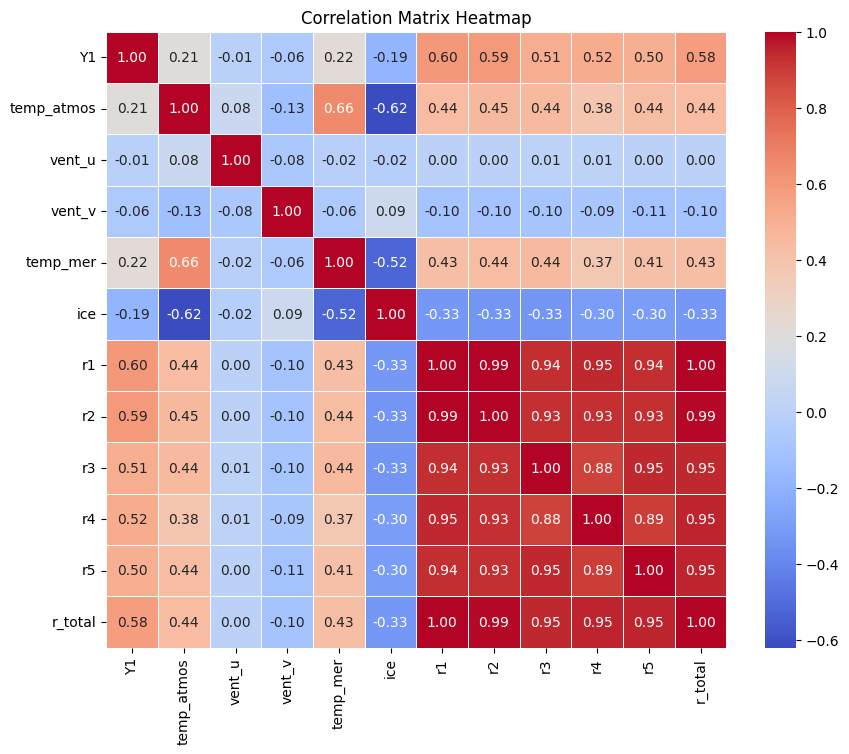

In [ ]:
df_total = pd.concat([df_infrason.drop(columns="date"),df_climat,df_sat,df_simu],axis=1)

corr_matrix = df_total.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

On constate que le concentration en glace est fortement corrélée aux températures atmosphérique et surfacique en mer, qui elles-mêmes sont corrélées entre elles. Cela est cohérent.

Les simulations de décharge par régions sont toutes très fortement corrélées entre elles. Celle à laquelle la cible est la plus corrélée est R1 qui correspond justement à la région où se situe Qaanaaq. On décide donc de supprimer les autres.

On remarque ausi qu'il y a une légère corrélation entre les décharges et la température. Il n'est peut-être pas judicieux cependant de les supprimer tout de suite.

### Finalisation du dataset

On supprime donc les régions autres que R1 et on ajoute les tendances de températures et de glace. On ajoute par ailleurs une variable cyclique (on prend celle sur la température atmosphérique car les autres suivent à peu près le même cycle). On a déjà remplacé les valeurs manquantes pour la concentration de glace. Il ne reste donc qu'à tout rassembler.

In [ ]:
df_total = pd.concat([df_climat,df_sat,df_simu[["r1"]]],axis=1)
df_total["target"] = var_bin

vent_u_trend = df_climat["vent_u"].rolling(365).mean()
vent_u_trend[:365] = df_climat["vent_u"][:365]
vent_v_trend = df_climat["vent_v"].rolling(365).mean()
vent_v_trend[:365] = df_climat["vent_v"][:365]

temp_atmos_trend, temp_period = fct.get_seasonality(df_climat["temp_atmos"].values,365)
temp_mer_trend, _ = fct.get_seasonality(df_climat["temp_mer"].values,365)
ice_trend, _ = fct.get_seasonality(df_sat["ice"].values,365)

df_total["vent_u_trend"] = vent_u_trend
df_total["vent_v_trend"] = vent_v_trend
df_total["temp_atmos_trend"] = temp_atmos_trend
df_total["temp_mer_trend"] = temp_mer_trend
df_total["ice_trend"] = ice_trend
df_total["cyclicity"] = temp_period

print("New shape : ", df_total.shape)
print("Features : ",list(df_total.columns))

New shape :  (2556, 13)
Features :  ['temp_atmos', 'vent_u', 'vent_v', 'temp_mer', 'ice', 'r1', 'target', 'vent_u_trend', 'vent_v_trend', 'temp_atmos_trend', 'temp_mer_trend', 'ice_trend', 'cyclicity']


In [ ]:
df_total.head()

,temp_atmos,vent_u,vent_v,temp_mer,ice,r1,target,vent_u_trend,vent_v_trend,temp_atmos_trend,temp_mer_trend,ice_trend,cyclicity
0,-21.926931,-0.973994,3.149094,-1.690511,90.745710,0.034537,0,-0.973994,3.149094,-9.305626,-0.831008,6.943819,-11.379094
1,-23.696195,-6.502908,2.494894,-1.690511,88.502980,0.034527,0,-6.502908,2.494894,-9.797965,-0.771089,5.336160,-11.376527
2,-25.644027,-3.557411,1.025486,-1.689860,88.734091,0.034523,0,-3.557411,1.025486,-10.272792,-0.770600,5.045819,-11.373961
3,-23.566887,-1.888075,-3.486122,-1.690511,89.149576,0.034509,0,-1.888075,-3.486122,-11.081380,-0.770682,6.059580,-11.371395
4,-22.897768,-2.748844,-3.491206,-1.689860,91.613955,0.034492,0,-2.748844,-3.491206,-11.705948,-0.770294,8.454118,-11.368828


## 4. Classification

### Prétraitement

Il est souvent recommandé de normaliser les données afin de garantir que toutes les caractéristiques contribuent de manière égale à l'apprentissage du modèle. Dans notre cas, les données n'ont pas les mêmes échelles (car grandeurs différentes). J'opte pour un Standard Scaler (qui réduit et normalise).

In [ ]:
from sklearn.preprocessing import StandardScaler

y = df_total["target"]
X = df_total.drop(columns=["target"])

#normalisation
scaler = StandardScaler()
X = scaler.fit_transform(X)

Ensuite, nous pourrions effectuer de la réduction de dimension, mais étant donné le faible nombre de features, ce n'est pas nécessaire ici. Il pourrait être intéressant aussi de retirer les valeurs aberrantes (notamment causées par les valeurs manquantes). Cependant, étant donné qu'on cherche à détecter des événemenents anormaux justement, il est préférable de ne pas les retirer tout de suite (d'autant plus qu'elles ne sont isolées).

### Modèles

Je réutilise ici le code fourni. On réalise de la cross validation pour évaluer les modèles. Par défault les divisions train test sont "stratified", c'est à dire que les proportions de labels postifs et négatifs sont respectées dans les deux sous ensembles. Il faudra faire attention aussi à utiliser des métriques qui prennent en compte cet misproportion (environ 90% de labels négatifs). Typiquement on ne peut pas utiliser l'accuracy.

In [48]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import sklearn.tree as Tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

n_samples, n_features = X.shape

models = {
    'gnb' : GaussianNB(),
    'lda' : LinearDiscriminantAnalysis(),
    'qda' : QuadraticDiscriminantAnalysis(),
    'logreg' : linear_model.LogisticRegression(C=1e5),
    'knn' : KNeighborsClassifier(n_neighbors=5),
    'tree' : Tree.DecisionTreeClassifier(),
    'RF' : RandomForestClassifier(max_depth=2, random_state=0,max_features=None,n_estimators=10),
    'xgb' : XGBClassifier(max_depth=2, random_state=0)}

N_models = len(models)
model_names = list(models.keys())

K=10
kfs = StratifiedKFold(n_splits=K, random_state=1, shuffle=True)

In [49]:
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

metric_names = ["auc","f1","precision","recall"]
train_metrics = {metric_name:{model_name:[] for model_name in model_names} for metric_name in metric_names}
test_metrics = {metric_name:{model_name:[] for model_name in model_names} for metric_name in metric_names}

for name, model in tqdm(models.items()):
  for train_index, test_index in kfs.split(X,y):
    X_train, X_test = X[train_index,:], X[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    y_pred_train, y_pred_test = model.predict(X_train), model.predict(X_test)

    train_metrics["auc"][name].append(metrics.roc_auc_score(y_train,y_pred_train))
    train_metrics["f1"][name].append(metrics.f1_score(y_train,y_pred_train))
    train_metrics["precision"][name].append(metrics.precision_score(y_train,y_pred_train))
    train_metrics["recall"][name].append(metrics.recall_score(y_train,y_pred_train))

    test_metrics["auc"][name].append(metrics.roc_auc_score(y_test,y_pred_test))
    test_metrics["f1"][name].append(metrics.f1_score(y_test,y_pred_test))
    test_metrics["precision"][name].append(metrics.precision_score(y_test,y_pred_test))
    test_metrics["recall"][name].append(metrics.recall_score(y_test,y_pred_test))

for metric_name in metric_names:
  train_metrics[metric_name] = pd.DataFrame(train_metrics[metric_name])
  test_metrics[metric_name] = pd.DataFrame(test_metrics[metric_name])

  0%|          | 0/8 [00:00<?, ?it/s]

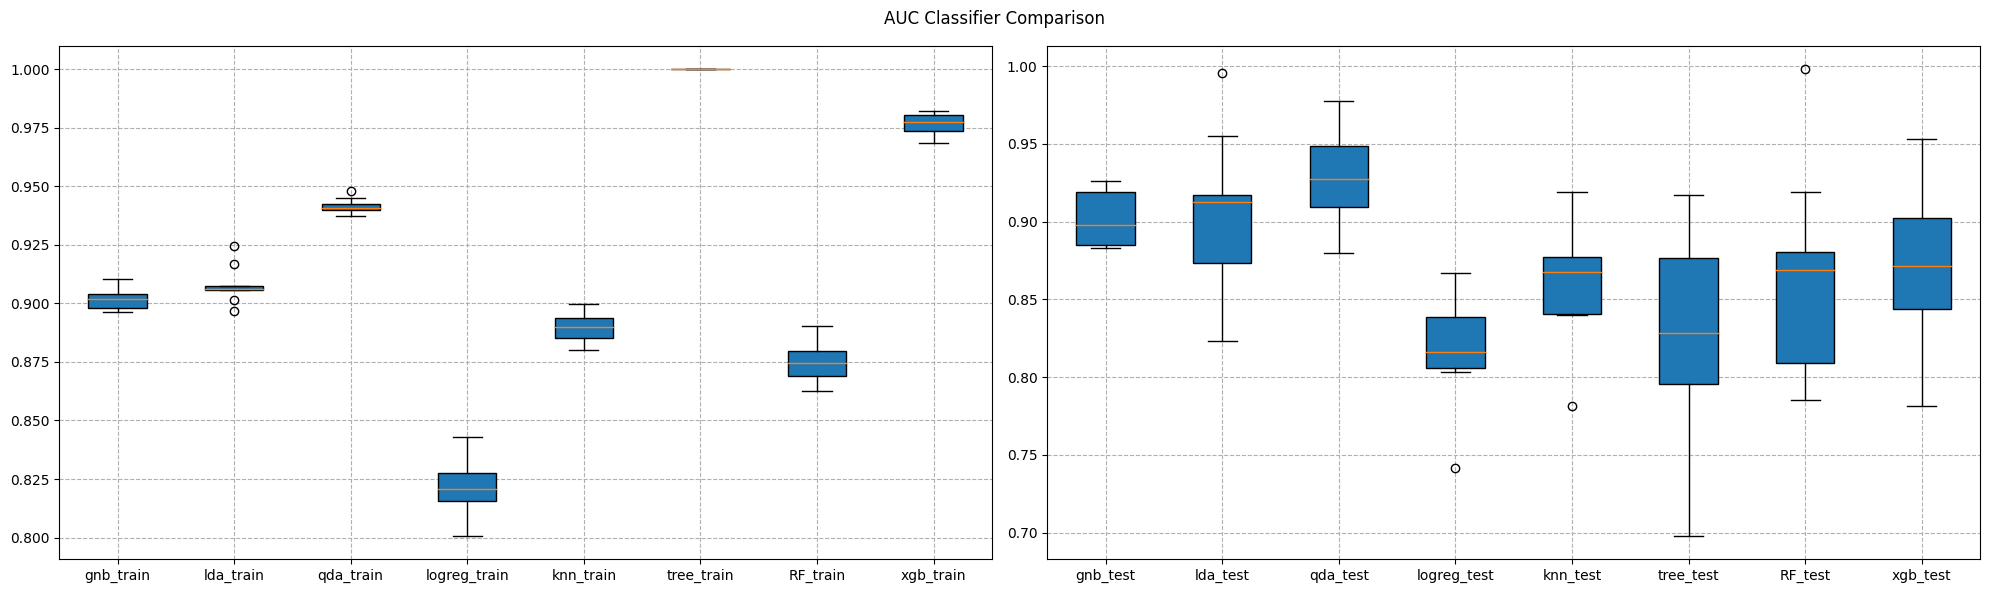

In [50]:
labels=np.concatenate(([i+'_train' for i,j in models.items()],[i+'_test' for i,j in models.items()]),axis=0)

fig, ax = plt.subplots(1,2,figsize=(20,6))

ax[0].boxplot(train_metrics["auc"],labels=[f'{model_name}_train' for model_name in model_names],patch_artist=True)
ax[1].boxplot(test_metrics["auc"],labels=[f'{model_name}_test' for model_name in model_names],patch_artist=True)

fig.suptitle("AUC Classifier Comparison")

for i in [0,1]:
  ax[i].grid(linestyle='--')

fig.tight_layout()

On s'aperçoit que les modèles probabilistes sont les plus performants sur les données de test. Le plus complexe est le modèle LDA. Du côté des modèles à base d'arbre, XGBoost semble avoir overfitté sur les données d'entraînement (très haute métrique de train mais moins bonne en test). Je vais voir si fine-tuner les hyperparamètres peut améliorer le score.

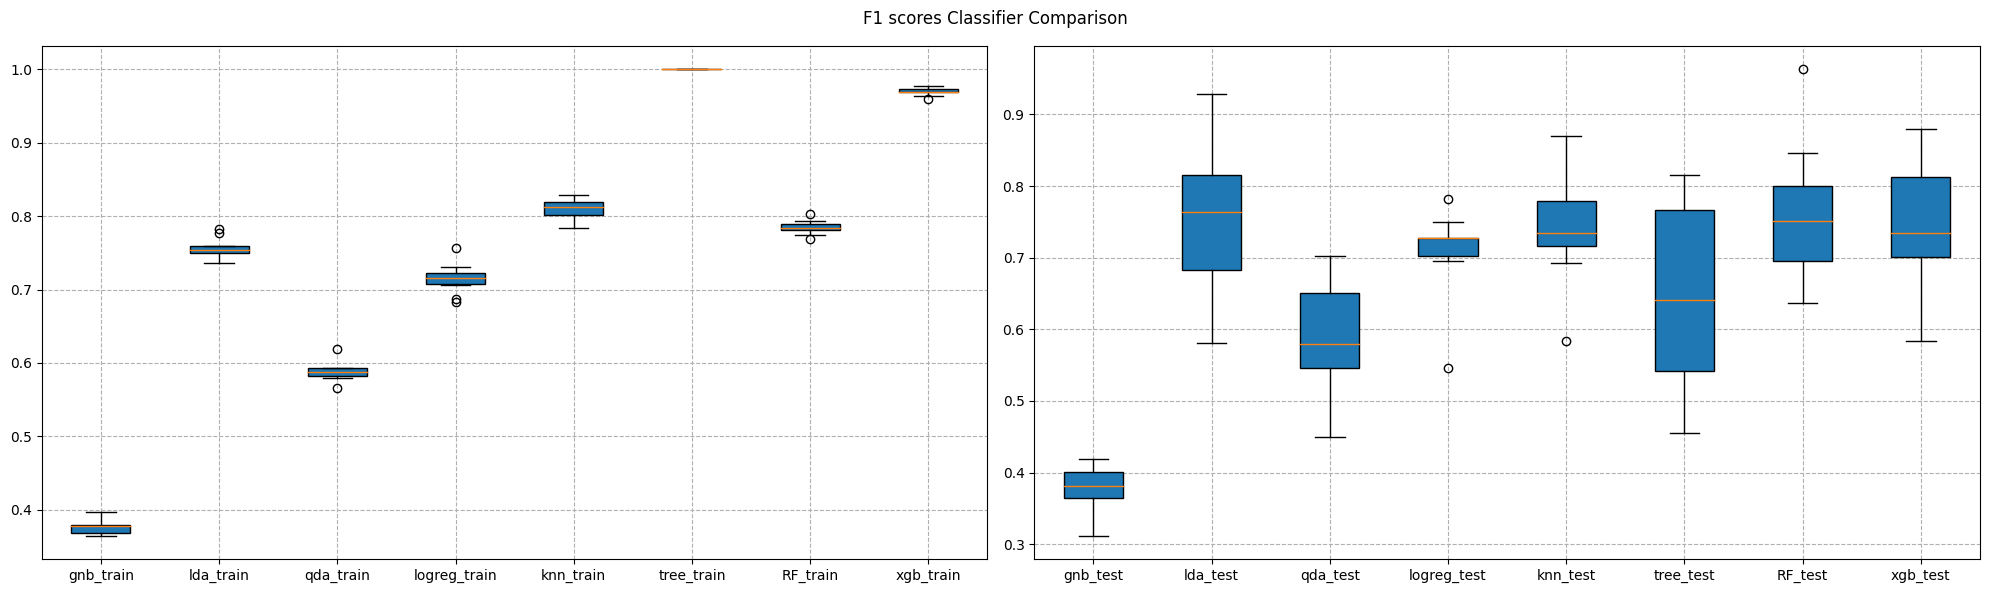

In [51]:
labels=np.concatenate(([i+'_train' for i,j in models.items()],[i+'_test' for i,j in models.items()]),axis=0)

fig, ax = plt.subplots(1,2,figsize=(20,6))

ax[0].boxplot(train_metrics["f1"],labels=[f'{model_name}_train' for model_name in model_names],patch_artist=True)
ax[1].boxplot(test_metrics["f1"],labels=[f'{model_name}_test' for model_name in model_names],patch_artist=True)

fig.suptitle("F1 scores Classifier Comparison")

for i in [0,1]:
  ax[i].grid(linestyle='--')

fig.tight_layout()

Je vais aussi m'intéresser au LDA car il semble être plus performant que QDA si on considère le F1 score plutôt que l'AUC.

In [66]:
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier()

params = {
    'n_estimators': [10,15,20,30,50,80,100],
    'max_depth': [5,7,10,12,15,20]
}

for metric in ["roc_auc","f1","f1_weighted"]:
  print("Metric : ",metric)
  grid_search = GridSearchCV(xgb, params, cv=10, scoring = metric)
  grid_search.fit(X, y)
  print("Params : ",grid_search.best_params_)
  print("Score : ",round(grid_search.best_score_,4))
  print("")

Metric :  roc_auc
Params :  {'max_depth': 7, 'n_estimators': 15}
Score :  0.971

Metric :  f1
Params :  {'max_depth': 5, 'n_estimators': 30}
Score :  0.5847

Metric :  f1_weighted
Params :  {'max_depth': 5, 'n_estimators': 30}
Score :  0.9593



In [64]:
from sklearn.model_selection import cross_val_score

models = [LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis()]
for model in models:
  print("-----")
  print("Model : ",model)
  print("")
  for metric in ["roc_auc","f1","f1_weighted"]:
    print("Metric : ",metric)
    print(round(np.mean(cross_val_score(model, X, y, cv=10, scoring=metric)),4))
    print("")
  print("")

-----
Model :  LinearDiscriminantAnalysis()

Metric :  roc_auc
0.9765

Metric :  f1
0.7499

Metric :  f1_weighted
0.9734


-----
Model :  QuadraticDiscriminantAnalysis()

Metric :  roc_auc
0.9633

Metric :  f1
0.6443

Metric :  f1_weighted
0.9466




C'est finalement la LDA qui l'emporte.

## 5. Résultats

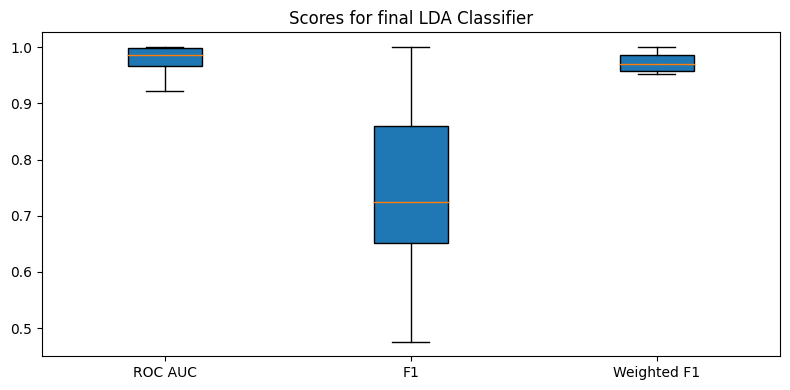

In [79]:
from sklearn.metrics import make_scorer

lda = LinearDiscriminantAnalysis() #modèle choisi

scoring = {
    'ROC AUC': 'roc_auc',
    'F1': 'f1',
    'Weighted F1': make_scorer(metrics.f1_score, average='weighted'),
}

labels = ['ROC AUC', 'F1', 'Weighted F1']

results = []
for metric, score_func in scoring.items():
    cv_scores = cross_val_score(lda, X, y, cv=10, scoring=score_func)
    results.append(cv_scores)

plt.figure(figsize=(8, 4))
plt.boxplot(results,labels=labels,patch_artist=True)
plt.title("Scores for final LDA Classifier")
plt.tight_layout()
plt.show()

On voit que les résultats sont globalement très satisfaisants si on se réfère à l'AUC ou le F1 pondéré. Cependant, c'est en réalité uniquement la détection d'événements positif qui nous intéresse, donc la bonne métrique à considérer est la F1 binaire classique (qui mesure que le F1 positif). Ainsi nous sommes plutôt à 0.7 en moyenne qu'à >0.9, et il y a une assez forte variabilité.

## 6. Conclusion

Dans ce TP, nous avons appris à analyser des séries temporelles en pratique avec python, avec notamment des données liées au climat et à l'environnement. Nous avons appris à les traiter de sorte à extraire les informations pertinentes afin d'entraîner des modèles d'apprentissages (en particulier de détection d'événements).

Nous avons ensuite selectionné le meilleur modèle pour notre cas d'usage et représenté les résultats sous forme interprêtable. Le résultat final est plutôt satisfaisant (AUC proche de 1 mais F1 binaire plutôt vers 0.7) ce qui suppose que notre compréhension des mécanismes liés aux événements climatiques qui se déroulent au Groenland - et donc de la fonte des glaces - peut s'améliorer.